In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from lightgbm import LGBMClassifier, plot_importance, LGBMRegressor
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, roc_auc_score, confusion_matrix
from gensim.models.word2vec import Word2Vec
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
import seaborn as sns

from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional, RNN, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import mean_absolute_error
from gensim.models import KeyedVectors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import tqdm
from konlpy.tag import Mecab
import pandas as pd
import re

m=Mecab(dicpath='C:/mecab/mecab-ko-dic') # 오류나시면 이부분 지우셔야합니다!


df = pd.read_csv("data.csv")
dic = pd.read_csv('./유의어_dictionary.csv', encoding = 'utf-8')
stop_words = pd.read_csv('C:\project_atm\preprocessing/불용어.csv', encoding = 'utf-8', index_col=None)

In [2]:
sns.set()
sns.set_context(font_scale = 0.6)

# 상승 하락 모델

## 데이터 불러오기

In [3]:
df = pd.read_csv("data.csv")
data = df.loc[:,['종목명','기사요약','label','등락률', 
                 '거래량','KOSPI200_등락률','환율변동률','유가변동률','S&P500_등락률']]

data.head()

,종목명,기사요약,label,등락률,거래량,KOSPI200_등락률,환율변동률,유가변동률,S&P500_등락률
0,SK이노베이션,SK이노베이션이 전기차용 배터리를 중심으로 하는 미래 모빌리티 혁신 기술을 대거 공...,1,-2.33%,217016,-1.16%,0.00%,-0.05%,0.29%
1,현대차,현대차 코나EV가 테슬라 모델3에 맞서는 전기차 강자로 떠올랐다.,1,-2.07%,556532,-1.16%,0.00%,-0.05%,0.29%
2,LG 화학,"LG화학, 전기차배터리가 화학 시황 침체 상쇄하고 남을 것으로 추정",1,-0.96%,165030,-1.16%,0.29%,3.12%,0.00%
3,SK이노베이션,SK이노베이션은 이번 전시회에서 모빌리티 관련 기술과 제품을 한데 모아 ‘SK 인사...,1,2.05%,274987,-1.16%,0.29%,3.12%,0.84%
4,현대차,현대차그룹은 2025년까지 미래 모빌리티 기술과 전략에 총 41조원 규모 투자를 단...,1,-1.69%,1145187,0.13%,0.29%,3.12%,0.84%


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1468 entries, 0 to 1467
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   종목명           1468 non-null   object
 1   기사요약          1468 non-null   object
 2   label         1468 non-null   int64 
 3   등락률           1468 non-null   object
 4   거래량           1468 non-null   int64 
 5   KOSPI200_등락률  1468 non-null   object
 6   환율변동률         1468 non-null   object
 7   유가변동률         1468 non-null   object
 8   S&P500_등락률    1468 non-null   object
dtypes: int64(2), object(7)
memory usage: 103.3+ KB


In [5]:
data

,종목명,기사요약,label,등락률,거래량,KOSPI200_등락률,환율변동률,유가변동률,S&P500_등락률
0,SK이노베이션,SK이노베이션이 전기차용 배터리를 중심으로 하는 미래 모빌리티 혁신 기술을 대거 공...,1,-2.33%,217016,-1.16%,0.00%,-0.05%,0.29%
1,현대차,현대차 코나EV가 테슬라 모델3에 맞서는 전기차 강자로 떠올랐다.,1,-2.07%,556532,-1.16%,0.00%,-0.05%,0.29%
2,LG 화학,"LG화학, 전기차배터리가 화학 시황 침체 상쇄하고 남을 것으로 추정",1,-0.96%,165030,-1.16%,0.29%,3.12%,0.00%
3,SK이노베이션,SK이노베이션은 이번 전시회에서 모빌리티 관련 기술과 제품을 한데 모아 ‘SK 인사...,1,2.05%,274987,-1.16%,0.29%,3.12%,0.84%
4,현대차,현대차그룹은 2025년까지 미래 모빌리티 기술과 전략에 총 41조원 규모 투자를 단...,1,-1.69%,1145187,0.13%,0.29%,3.12%,0.84%
...,...,...,...,...,...,...,...,...,...
1463,삼성sdi,CATL은 2020년 하반기부터는 중국에서 판매하는 테슬라 모델3에도 배터리 공급을...,0,6.85%,694737,2.72%,0.02%,-2.11%,0.64%
1464,삼성sdi,중국 배터리 기업 CATL이 세계 전기차 배터리 시장에서 LG에너지솔루션과 격차를 ...,0,6.85%,694737,2.72%,0.02%,-2.11%,0.64%
1465,삼성sdi,"CATL, CATL, 올해 글로벌 전기 자동차 배터리 시장에서 먼저 순위가 있으며 ...",0,6.85%,694737,2.72%,0.02%,-2.11%,0.64%
1466,삼성sdi,CATL은 201020 년부터 중국까지 중국에서 판매되는 테슬라 모델에서 배터리를 ...,0,6.85%,694737,2.72%,0.02%,-2.11%,0.64%


In [6]:
data = data.astype({'거래량': 'str'})
data['거래량'] = data['거래량'].str.replace('%', '')
data = data.astype({'거래량': 'float'})
data['거래량'] = data['거래량']

data = data.astype({'등락률': 'str'})
data['등락률'] = data['등락률'].str.replace('%', '')
data = data.astype({'등락률': 'float'})
data['등락률'] = data['등락률'] / 100

data = data.astype({'KOSPI200_등락률': 'str'})
data['KOSPI200_등락률'] = data['KOSPI200_등락률'].str.replace('%', '')
data = data.astype({'KOSPI200_등락률': 'float'})
data['KOSPI200_등락률'] = data['KOSPI200_등락률'] / 100

data = data.astype({'환율변동률': 'str'})
data['환율변동률'] = data['환율변동률'].str.replace('%', '')
data = data.astype({'환율변동률': 'float'})
data['환율변동률'] = data['환율변동률'] / 100

data = data.astype({'유가변동률': 'str'})
data['유가변동률'] = data['유가변동률'].str.replace('%', '')
data = data.astype({'유가변동률': 'float'})
data['유가변동률'] = data['유가변동률'] / 100

data = data.astype({'S&P500_등락률': 'str'})
data['S&P500_등락률'] = data['S&P500_등락률'].str.replace('%', '')
data = data.astype({'S&P500_등락률': 'float'})
data['S&P500_등락률'] = data['S&P500_등락률'] / 100


In [7]:
data

,종목명,기사요약,label,등락률,거래량,KOSPI200_등락률,환율변동률,유가변동률,S&P500_등락률
0,SK이노베이션,SK이노베이션이 전기차용 배터리를 중심으로 하는 미래 모빌리티 혁신 기술을 대거 공...,1,-0.0233,217016.0,-0.0116,0.0000,-0.0005,0.0029
1,현대차,현대차 코나EV가 테슬라 모델3에 맞서는 전기차 강자로 떠올랐다.,1,-0.0207,556532.0,-0.0116,0.0000,-0.0005,0.0029
2,LG 화학,"LG화학, 전기차배터리가 화학 시황 침체 상쇄하고 남을 것으로 추정",1,-0.0096,165030.0,-0.0116,0.0029,0.0312,0.0000
3,SK이노베이션,SK이노베이션은 이번 전시회에서 모빌리티 관련 기술과 제품을 한데 모아 ‘SK 인사...,1,0.0205,274987.0,-0.0116,0.0029,0.0312,0.0084
4,현대차,현대차그룹은 2025년까지 미래 모빌리티 기술과 전략에 총 41조원 규모 투자를 단...,1,-0.0169,1145187.0,0.0013,0.0029,0.0312,0.0084
...,...,...,...,...,...,...,...,...,...
1463,삼성sdi,CATL은 2020년 하반기부터는 중국에서 판매하는 테슬라 모델3에도 배터리 공급을...,0,0.0685,694737.0,0.0272,0.0002,-0.0211,0.0064
1464,삼성sdi,중국 배터리 기업 CATL이 세계 전기차 배터리 시장에서 LG에너지솔루션과 격차를 ...,0,0.0685,694737.0,0.0272,0.0002,-0.0211,0.0064
1465,삼성sdi,"CATL, CATL, 올해 글로벌 전기 자동차 배터리 시장에서 먼저 순위가 있으며 ...",0,0.0685,694737.0,0.0272,0.0002,-0.0211,0.0064
1466,삼성sdi,CATL은 201020 년부터 중국까지 중국에서 판매되는 테슬라 모델에서 배터리를 ...,0,0.0685,694737.0,0.0272,0.0002,-0.0211,0.0064


In [8]:
volume = []
for x in range(len(data['거래량'])):
    temp = (data['거래량'][x]-data['거래량'].min())/(data['거래량'].max()-data['거래량'].min())
    volume.append(temp)
    
for x in range(len(data['거래량'])):
    data['거래량'][x] = volume[x]

C:\Users\user\anaconda3\envs\atm\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [9]:
data

,종목명,기사요약,label,등락률,거래량,KOSPI200_등락률,환율변동률,유가변동률,S&P500_등락률
0,SK이노베이션,SK이노베이션이 전기차용 배터리를 중심으로 하는 미래 모빌리티 혁신 기술을 대거 공...,1,-0.0233,0.009961,-0.0116,0.0000,-0.0005,0.0029
1,현대차,현대차 코나EV가 테슬라 모델3에 맞서는 전기차 강자로 떠올랐다.,1,-0.0207,0.061206,-0.0116,0.0000,-0.0005,0.0029
2,LG 화학,"LG화학, 전기차배터리가 화학 시황 침체 상쇄하고 남을 것으로 추정",1,-0.0096,0.002114,-0.0116,0.0029,0.0312,0.0000
3,SK이노베이션,SK이노베이션은 이번 전시회에서 모빌리티 관련 기술과 제품을 한데 모아 ‘SK 인사...,1,0.0205,0.018711,-0.0116,0.0029,0.0312,0.0084
4,현대차,현대차그룹은 2025년까지 미래 모빌리티 기술과 전략에 총 41조원 규모 투자를 단...,1,-0.0169,0.150054,0.0013,0.0029,0.0312,0.0084
...,...,...,...,...,...,...,...,...,...
1463,삼성sdi,CATL은 2020년 하반기부터는 중국에서 판매하는 테슬라 모델3에도 배터리 공급을...,0,0.0685,0.082065,0.0272,0.0002,-0.0211,0.0064
1464,삼성sdi,중국 배터리 기업 CATL이 세계 전기차 배터리 시장에서 LG에너지솔루션과 격차를 ...,0,0.0685,0.082065,0.0272,0.0002,-0.0211,0.0064
1465,삼성sdi,"CATL, CATL, 올해 글로벌 전기 자동차 배터리 시장에서 먼저 순위가 있으며 ...",0,0.0685,0.082065,0.0272,0.0002,-0.0211,0.0064
1466,삼성sdi,CATL은 201020 년부터 중국까지 중국에서 판매되는 테슬라 모델에서 배터리를 ...,0,0.0685,0.082065,0.0272,0.0002,-0.0211,0.0064


In [10]:
for x in range(len(data['등락률'])):
    if data['등락률'][x] > 0:
        data['등락률'][x] = 1
    else:
        data['등락률'][x] = 0

        
data

C:\Users\user\anaconda3\envs\atm\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\user\anaconda3\envs\atm\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,종목명,기사요약,label,등락률,거래량,KOSPI200_등락률,환율변동률,유가변동률,S&P500_등락률
0,SK이노베이션,SK이노베이션이 전기차용 배터리를 중심으로 하는 미래 모빌리티 혁신 기술을 대거 공...,1,0.0,0.009961,-0.0116,0.0000,-0.0005,0.0029
1,현대차,현대차 코나EV가 테슬라 모델3에 맞서는 전기차 강자로 떠올랐다.,1,0.0,0.061206,-0.0116,0.0000,-0.0005,0.0029
2,LG 화학,"LG화학, 전기차배터리가 화학 시황 침체 상쇄하고 남을 것으로 추정",1,0.0,0.002114,-0.0116,0.0029,0.0312,0.0000
3,SK이노베이션,SK이노베이션은 이번 전시회에서 모빌리티 관련 기술과 제품을 한데 모아 ‘SK 인사...,1,1.0,0.018711,-0.0116,0.0029,0.0312,0.0084
4,현대차,현대차그룹은 2025년까지 미래 모빌리티 기술과 전략에 총 41조원 규모 투자를 단...,1,0.0,0.150054,0.0013,0.0029,0.0312,0.0084
...,...,...,...,...,...,...,...,...,...
1463,삼성sdi,CATL은 2020년 하반기부터는 중국에서 판매하는 테슬라 모델3에도 배터리 공급을...,0,1.0,0.082065,0.0272,0.0002,-0.0211,0.0064
1464,삼성sdi,중국 배터리 기업 CATL이 세계 전기차 배터리 시장에서 LG에너지솔루션과 격차를 ...,0,1.0,0.082065,0.0272,0.0002,-0.0211,0.0064
1465,삼성sdi,"CATL, CATL, 올해 글로벌 전기 자동차 배터리 시장에서 먼저 순위가 있으며 ...",0,1.0,0.082065,0.0272,0.0002,-0.0211,0.0064
1466,삼성sdi,CATL은 201020 년부터 중국까지 중국에서 판매되는 테슬라 모델에서 배터리를 ...,0,1.0,0.082065,0.0272,0.0002,-0.0211,0.0064


## 유의어 대치 후 정규화

In [11]:
stripping = re.compile('[^ ㄱ-ㅣ가-힣+]') # 숫자, 영어제거
for x in tqdm.tqdm(range(data['기사요약'].shape[0])):
    for i in range(dic.shape[0]):
        data['기사요약'][x] = re.sub(dic['values'][i], dic['key'][i], data['기사요약'][x])
          
    data['기사요약'][x] = stripping.sub('',data['기사요약'][x])
data['기사요약']

  0%|                                                                                         | 0/1468 [00:00<?, ?it/s]C:\Users\user\anaconda3\envs\atm\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\user\anaconda3\envs\atm\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
100%|██████████████████████████████████████████████████████████████████████████████| 1468/1468 [00:26<00:00, 56.39it/s]


0       에스케이이노베이션이 전기차배터리를 중심으로 하는 모빌리티 이노베이션 기술을 대거 공...
1                        현대차 코나이브이가 모델 에 맞서는 전기차 강자로 떠올랐다
2                    엘지화학 전기차배터리가 화학 시황 침체 상쇄하고 남을 것으로 추정
3       에스케이이노베이션은 이번 전시회에서 모빌리티 관련 기술과 제품을 한데 모아 에스케이...
4          현대차그룹은     년까지 모빌리티 기술과 전략에 총   조원 규모 투자를 단행한다
                              ...                        
1463      중국기업은     년 하반기부터는 중국에서 판매하는 모델 에도 배터리 공급을 시작했다
1464    중국 배터리 기업 중국기업이 세계 전기차배터리 시장에서 엘지에너지솔루션과 격차를 벌...
1465    중국기업 중국기업 올해 글로벌 전기 자동차 배터리 시장에서 먼저 순위가 있으며 시장...
1466    중국기업은        년부터 중국까지 중국에서 판매되는 테슬라 모델에서 배터리를 ...
1467    중국 배터리 공사 중국기업은 엘지 전자 전기 자동차 배터리 시장에서 엘지 에너지 솔...
Name: 기사요약, Length: 1468, dtype: object

## 불용어 제거 함수

In [12]:
def func(text):
    clean = []
    for word in tqdm.tqdm(m.morphs(text)): #어간 추출
        if word not in list(stop_words['stop_words']): #조사, 어미, 구두점 제외 
            clean.append(word)
    
    
    return " ".join(clean)

### 불용어 제거 및 단어로 토큰화

In [13]:
data['tokenized'] = data['기사요약'].apply(lambda x : func(x))
data['tokenized']

100%|███████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 22979.75it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<?, ?it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 28981.37it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 52877.76it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 15974.50it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<?, ?it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 15036.94it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<?, ?it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 39993.36it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<?, ?it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 17062.26it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 10995.55it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<?, ?it/s]
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)


100%|███████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 16989.08it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 20996.52it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<?, ?it/s]


0       에스케이 이노베이션 전기차배터리 중심 모빌리티 이노베이션 기술 대거 공개 제품 고객...
1                              현대차 코나이브이 모델 맞서 전기차 강자 떠올랐
2                              엘지화학 전기차배터리 화학 시황 침체 상쇄 추정
3       에스케이이노베이션 전시회 모빌리티 기술 제품 에스케이 인사이드 캐치프레이즈 공개 인...
4                                  현대차그룹 모빌리티 기술 전략 투자 단행
                              ...                        
1463                            중국 기업 하반기 중국 판매 모델 배터리 공급
1464       중국 배터리 기업 중국 기업 세계 전기차배터리 시장 엘지에너지솔루션 개월 연속 자리
1465    중국 기업 중국 기업 글로벌 전기 자동차 배터리 시장 먼저 순위 시장 시장점유율 첫...
1466                         중국 기업 중국 중국 판매 테슬라 모델 배터리 공급
1467    중국 배터리 공사 중국 기업 엘지 전자 전기 자동차 배터리 시장 엘지 에너지 솔루션...
Name: tokenized, Length: 1468, dtype: object

In [14]:
result = []
for sentence in tqdm.tqdm(data['기사요약']):
    temp_X = m.morphs(sentence) # 토큰화
    temp_X = [word for word in temp_X if not word in list(stop_words['stop_words'])] # 불용어 제거
    result.append(temp_X)

data['확인'] = result
data['확인']

100%|████████████████████████████████████████████████████████████████████████████| 1468/1468 [00:00<00:00, 1729.04it/s]


0       [에스케이, 이노베이션, 전기차배터리, 중심, 모빌리티, 이노베이션, 기술, 대거,...
1                      [현대차, 코나이브이, 모델, 맞서, 전기차, 강자, 떠올랐]
2                       [엘지화학, 전기차배터리, 화학 시황, 침체, 상쇄, 추정]
3       [에스케이이노베이션, 전시회, 모빌리티, 기술, 제품, 에스케이, 인사이드, 캐치프...
4                           [현대차그룹, 모빌리티, 기술, 전략, 투자, 단행]
                              ...                        
1463                   [중국, 기업, 하반기, 중국, 판매, 모델, 배터리, 공급]
1464    [중국, 배터리, 기업, 중국, 기업, 세계, 전기차배터리, 시장, 엘지에너지솔루션...
1465    [중국, 기업, 중국, 기업, 글로벌, 전기, 자동차, 배터리, 시장, 먼저, 순위...
1466               [중국, 기업, 중국, 중국, 판매, 테슬라, 모델, 배터리, 공급]
1467    [중국, 배터리, 공사, 중국, 기업, 엘지, 전자, 전기, 자동차, 배터리, 시장...
Name: 확인, Length: 1468, dtype: object

In [15]:
data['tokenized']

0       에스케이 이노베이션 전기차배터리 중심 모빌리티 이노베이션 기술 대거 공개 제품 고객...
1                              현대차 코나이브이 모델 맞서 전기차 강자 떠올랐
2                              엘지화학 전기차배터리 화학 시황 침체 상쇄 추정
3       에스케이이노베이션 전시회 모빌리티 기술 제품 에스케이 인사이드 캐치프레이즈 공개 인...
4                                  현대차그룹 모빌리티 기술 전략 투자 단행
                              ...                        
1463                            중국 기업 하반기 중국 판매 모델 배터리 공급
1464       중국 배터리 기업 중국 기업 세계 전기차배터리 시장 엘지에너지솔루션 개월 연속 자리
1465    중국 기업 중국 기업 글로벌 전기 자동차 배터리 시장 먼저 순위 시장 시장점유율 첫...
1466                         중국 기업 중국 중국 판매 테슬라 모델 배터리 공급
1467    중국 배터리 공사 중국 기업 엘지 전자 전기 자동차 배터리 시장 엘지 에너지 솔루션...
Name: tokenized, Length: 1468, dtype: object

## TF-IDF를 통한 Vectorization

In [16]:
tfidf_vect = TfidfVectorizer()
tfidf_vect.fit(data['tokenized'])
tfidf_dict = tfidf_vect.get_feature_names()
tfidf_matrix_train = tfidf_vect.transform(data['tokenized'])

In [17]:
tfidf_matrix_train.shape

(1468, 3151)

## train/test dataset 나누기

In [18]:
def split_dataset(tfidf,df):
    X_data = tfidf
    y_data = df['label']

    # stratify=y_data Stratified 기반 분할, train 데이터의 30%를 평가 데이터 셋으로 사용. (70% 데이터 학습에 사용)
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.25, random_state = 5)

    
    return (X_train, X_test, y_train, y_test)

X_train, X_test, y_train, y_test = split_dataset(tfidf_matrix_train,data)

## baseline modeling (lightGBM)

In [19]:
lgbm = LGBMClassifier(random_state = 10)
lgbm.fit(X_train,y_train, verbose = True)
pred = lgbm.predict(X_test)

### 모델 평가

In [20]:
def get_clf_eval(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)
    AUC =  roc_auc_score(y_test, y_pred)
    print('오차행렬:\n', confusion)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

In [21]:
get_clf_eval(y_test, pred)

오차행렬:
 [[ 99  29]
 [ 26 213]]

정확도: 0.8501
정밀도: 0.8802
재현율: 0.8912
F1: 0.8857
AUC: 0.8323


## bilstm 성능확인 (TF-IDF 인코딩)

In [22]:
X_train = X_train.toarray()
X_test = X_test.toarray()

In [23]:
X_train = X_train.reshape(X_train.shape[0],1,X_train.shape[-1])
X_test = X_test.reshape(X_test.shape[0],1,X_test.shape[-1])

In [24]:
model = Sequential([
                    tf.keras.layers.Bidirectional(LSTM(units = 64, return_sequences = True), input_shape=(1, tfidf_matrix_train.shape[1])),
                    tf.keras.layers.Bidirectional(LSTM(units = 64, return_sequences = True)),
                    tf.keras.layers.Dropout(0.3),
                    tf.keras.layers.Bidirectional(LSTM(units = 32, return_sequences = True)),
                    tf.keras.layers.Bidirectional(LSTM(units = 32, return_sequences = True)),
                    tf.keras.layers.Dropout(0.3),
                    tf.keras.layers.Bidirectional(LSTM(units = 16, return_sequences = True)),
                    tf.keras.layers.Bidirectional(LSTM(units = 16, return_sequences = True)),
                    tf.keras.layers.Dropout(0.3),
                    tf.keras.layers.Bidirectional(LSTM(units = 8, return_sequences = True)),
                    tf.keras.layers.Bidirectional(LSTM(units = 8, return_sequences = True)),
                    tf.keras.layers.Flatten(),
                    Dense(1, activation='sigmoid')    # 결과값이 0~1 이므로 Dense(1)
                    ])
    
model.compile(loss= 'binary_crossentropy', #여러개 정답 중 하나 맞추는 문제이므로 손실 함수는 categorical_crossentropy
              optimizer= 'rmsprop',
              metrics = ['accuracy']) 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 1, 128)            1646592   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1, 128)            98816     
_________________________________________________________________
dropout (Dropout)            (None, 1, 128)            0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 1, 64)             41216     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 1, 64)             24832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 64)             0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 1, 32)             1

In [25]:
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', patience = 50)
history1 = model.fit(X_train, y_train, epochs=100, callbacks=[mc,es], batch_size=100, validation_split=0.2)

Epoch 1/100
9/9 [==============================] - ETA: 0s - loss: 0.6910 - accuracy: 0.5920
Epoch 00001: val_loss improved from inf to 0.69115, saving model to best_model.h5
9/9 [==============================] - 4s 397ms/step - loss: 0.6910 - accuracy: 0.5920 - val_loss: 0.6911 - val_accuracy: 0.5566
Epoch 2/100
9/9 [==============================] - ETA: 0s - loss: 0.6875 - accuracy: 0.6182
Epoch 00002: val_loss improved from 0.69115 to 0.68980, saving model to best_model.h5
9/9 [==============================] - 0s 38ms/step - loss: 0.6875 - accuracy: 0.6182 - val_loss: 0.6898 - val_accuracy: 0.5566
Epoch 3/100
9/9 [==============================] - ETA: 0s - loss: 0.6839 - accuracy: 0.6182
Epoch 00003: val_loss improved from 0.68980 to 0.68826, saving model to best_model.h5
9/9 [==============================] - 0s 42ms/step - loss: 0.6839 - accuracy: 0.6182 - val_loss: 0.6883 - val_accuracy: 0.5566
Epoch 4/100
9/9 [==============================] - ETA: 0s - loss: 0.6771 - accura

Epoch 30/100
9/9 [==============================] - ETA: 0s - loss: 0.0463 - accuracy: 0.9989
Epoch 00030: val_loss did not improve from 0.50914
9/9 [==============================] - 0s 30ms/step - loss: 0.0463 - accuracy: 0.9989 - val_loss: 0.5350 - val_accuracy: 0.8462
Epoch 31/100
9/9 [==============================] - ETA: 0s - loss: 0.0410 - accuracy: 0.9989
Epoch 00031: val_loss did not improve from 0.50914
9/9 [==============================] - 0s 36ms/step - loss: 0.0410 - accuracy: 0.9989 - val_loss: 0.5473 - val_accuracy: 0.8371
Epoch 32/100
9/9 [==============================] - ETA: 0s - loss: 0.0363 - accuracy: 0.9989
Epoch 00032: val_loss did not improve from 0.50914
9/9 [==============================] - 0s 34ms/step - loss: 0.0363 - accuracy: 0.9989 - val_loss: 0.5475 - val_accuracy: 0.8416
Epoch 33/100
9/9 [==============================] - ETA: 0s - loss: 0.0322 - accuracy: 0.9989
Epoch 00033: val_loss did not improve from 0.50914
9/9 [==============================]

9/9 [==============================] - ETA: 0s - loss: 0.0090 - accuracy: 0.9989
Epoch 00060: val_loss did not improve from 0.50914
9/9 [==============================] - 0s 32ms/step - loss: 0.0090 - accuracy: 0.9989 - val_loss: 1.0634 - val_accuracy: 0.8371


In [26]:
loaded_model = load_model('best_model.h5')
print("테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

12/12 [==============================] - 0s 3ms/step - loss: 0.3771 - accuracy: 0.8828
테스트 정확도: 0.8828


In [27]:
tfidf_matrix_train = tfidf_matrix_train.toarray()
tf_matrix = tfidf_matrix_train.reshape(tfidf_matrix_train.shape[0],1,tfidf_matrix_train.shape[-1])

In [28]:
pred = model.predict(tf_matrix)

In [29]:
pred

array([[0.9989151 ],
       [0.99891555],
       [0.9989151 ],
       ...,
       [0.00160131],
       [0.00160152],
       [0.0016025 ]], dtype=float32)

In [30]:
data['label']

0       1
1       1
2       1
3       1
4       1
       ..
1463    0
1464    0
1465    0
1466    0
1467    0
Name: label, Length: 1468, dtype: int64

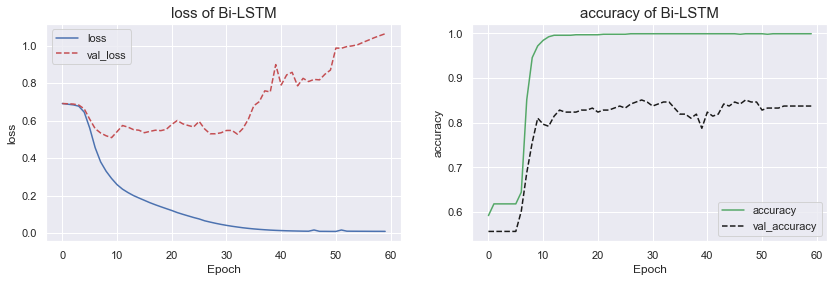

In [31]:
# Bi-LSTM 모델 학습 결과 확인
plt.figure(figsize=(14, 4))
plt.title('Bi-LSTM (model1) ', fontsize= 15)

plt.subplot(1, 2, 1)
plt.title('loss of Bi-LSTM', fontsize= 15)
plt.plot(history1.history['loss'], 'b-', label='loss')
plt.plot(history1.history['val_loss'],'r--', label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('accuracy of Bi-LSTM', fontsize= 15)
plt.plot(history1.history['accuracy'], 'g-', label='accuracy')
plt.plot(history1.history['val_accuracy'],'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show
plt.savefig('Bi-LSTM.png')

# 주가 상승 하락 예측 (자연어 가중치 추가)

In [32]:
data[['pred']] = pred

In [33]:
data = data[['종목명','거래량','KOSPI200_등락률','환율변동률','유가변동률','S&P500_등락률','등락률','pred']]
data

,종목명,거래량,KOSPI200_등락률,환율변동률,유가변동률,S&P500_등락률,등락률,pred
0,SK이노베이션,0.009961,-0.0116,0.0000,-0.0005,0.0029,0.0,0.998915
1,현대차,0.061206,-0.0116,0.0000,-0.0005,0.0029,0.0,0.998916
2,LG 화학,0.002114,-0.0116,0.0029,0.0312,0.0000,0.0,0.998915
3,SK이노베이션,0.018711,-0.0116,0.0029,0.0312,0.0084,1.0,0.998917
4,현대차,0.150054,0.0013,0.0029,0.0312,0.0084,0.0,0.998917
...,...,...,...,...,...,...,...,...
1463,삼성sdi,0.082065,0.0272,0.0002,-0.0211,0.0064,1.0,0.001606
1464,삼성sdi,0.082065,0.0272,0.0002,-0.0211,0.0064,1.0,0.001609
1465,삼성sdi,0.082065,0.0272,0.0002,-0.0211,0.0064,1.0,0.001601
1466,삼성sdi,0.082065,0.0272,0.0002,-0.0211,0.0064,1.0,0.001602


In [34]:
X_data = data[['거래량','KOSPI200_등락률','환율변동률','유가변동률','S&P500_등락률','pred']]
y_data = data[['등락률']]

In [35]:
X_data

,거래량,KOSPI200_등락률,환율변동률,유가변동률,S&P500_등락률,pred
0,0.009961,-0.0116,0.0000,-0.0005,0.0029,0.998915
1,0.061206,-0.0116,0.0000,-0.0005,0.0029,0.998916
2,0.002114,-0.0116,0.0029,0.0312,0.0000,0.998915
3,0.018711,-0.0116,0.0029,0.0312,0.0084,0.998917
4,0.150054,0.0013,0.0029,0.0312,0.0084,0.998917
...,...,...,...,...,...,...
1463,0.082065,0.0272,0.0002,-0.0211,0.0064,0.001606
1464,0.082065,0.0272,0.0002,-0.0211,0.0064,0.001609
1465,0.082065,0.0272,0.0002,-0.0211,0.0064,0.001601
1466,0.082065,0.0272,0.0002,-0.0211,0.0064,0.001602


In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.20, random_state = 5)

In [37]:
lgbm = LGBMClassifier(random_state = 10)
model = lgbm.fit(X_train,y_train, verbose = True, eval_set = [(X_train, y_train), (X_test, y_test)], eval_metric = 'auc')
prediction = lgbm.predict(X_test)

[1]	training's auc: 0.917377	training's binary_logloss: 0.639827	valid_1's auc: 0.854839	valid_1's binary_logloss: 0.655965
[2]	training's auc: 0.927672	training's binary_logloss: 0.597147	valid_1's auc: 0.869738	valid_1's binary_logloss: 0.619779
[3]	training's auc: 0.937061	training's binary_logloss: 0.562957	valid_1's auc: 0.871362	valid_1's binary_logloss: 0.592814
[4]	training's auc: 0.942191	training's binary_logloss: 0.529701	valid_1's auc: 0.881063	valid_1's binary_logloss: 0.565897
[5]	training's auc: 0.947773	training's binary_logloss: 0.500577	valid_1's auc: 0.887004	valid_1's binary_logloss: 0.542269
[6]	training's auc: 0.95246	training's binary_logloss: 0.47581	valid_1's auc: 0.89508	valid_1's binary_logloss: 0.520711
[7]	training's auc: 0.954449	training's binary_logloss: 0.453553	valid_1's auc: 0.900812	valid_1's binary_logloss: 0.501211
[8]	training's auc: 0.957438	training's binary_logloss: 0.431601	valid_1's auc: 0.90304	valid_1's binary_logloss: 0.485214
[9]	training

C:\Users\user\anaconda3\envs\atm\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


C:\Users\user\anaconda3\envs\atm\lib\site-packages\lightgbm\plotting.py:328: UserWarning: More than one metric available, picking one to plot.
  _log_warning("More than one metric available, picking one to plot.")


<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

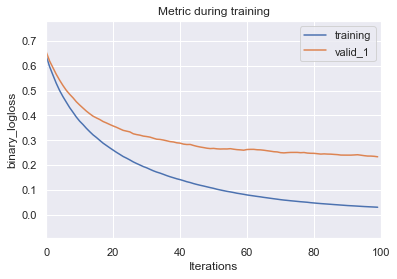

In [38]:
lgb.plot_metric(lgbm)

In [39]:
get_clf_eval(y_test, prediction)

오차행렬:
 [[131   8]
 [ 15 140]]

정확도: 0.9218
정밀도: 0.9459
재현율: 0.9032
F1: 0.9241
AUC: 0.9228


[Text(0.5, 1.0, '주가 상승하락 예측모델 특성 중요도'),
 Text(0.5, 0, '특성 중요도'),
 Text(0, 0.5, '특성')]

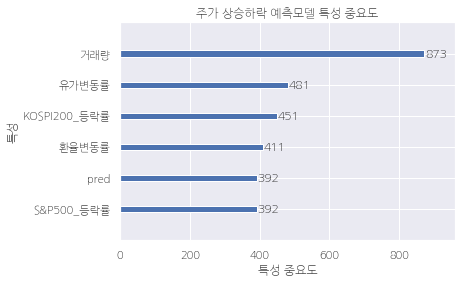

In [40]:
import seaborn as sns
plt.rcParams['font.family'] = 'NanumGothic'



ax = plot_importance(lgbm, importance_type='split')
ax.set(title=f'주가 상승하락 예측모델 특성 중요도',
    xlabel='특성 중요도',
    ylabel='특성')

# 주가 상승 하락 예측 (자연어 X)

In [41]:
data = data[['종목명','거래량','KOSPI200_등락률','환율변동률','유가변동률','S&P500_등락률','등락률']]
data

,종목명,거래량,KOSPI200_등락률,환율변동률,유가변동률,S&P500_등락률,등락률
0,SK이노베이션,0.009961,-0.0116,0.0000,-0.0005,0.0029,0.0
1,현대차,0.061206,-0.0116,0.0000,-0.0005,0.0029,0.0
2,LG 화학,0.002114,-0.0116,0.0029,0.0312,0.0000,0.0
3,SK이노베이션,0.018711,-0.0116,0.0029,0.0312,0.0084,1.0
4,현대차,0.150054,0.0013,0.0029,0.0312,0.0084,0.0
...,...,...,...,...,...,...,...
1463,삼성sdi,0.082065,0.0272,0.0002,-0.0211,0.0064,1.0
1464,삼성sdi,0.082065,0.0272,0.0002,-0.0211,0.0064,1.0
1465,삼성sdi,0.082065,0.0272,0.0002,-0.0211,0.0064,1.0
1466,삼성sdi,0.082065,0.0272,0.0002,-0.0211,0.0064,1.0


In [42]:
X_data = data[['거래량','KOSPI200_등락률','환율변동률','유가변동률','S&P500_등락률']]
y_data = data[['등락률']]

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.20, random_state = 5)

In [44]:
lgbm = LGBMClassifier(random_state = 10)
model = lgbm.fit(X_train,y_train, verbose = True, eval_set = [(X_train, y_train), (X_test, y_test)], eval_metric = 'auc')
prediction = lgbm.predict(X_test)

[1]	training's auc: 0.909969	training's binary_logloss: 0.641625	valid_1's auc: 0.875307	valid_1's binary_logloss: 0.654817
[2]	training's auc: 0.925554	training's binary_logloss: 0.59778	valid_1's auc: 0.88965	valid_1's binary_logloss: 0.616671
[3]	training's auc: 0.928592	training's binary_logloss: 0.561926	valid_1's auc: 0.89819	valid_1's binary_logloss: 0.583207
[4]	training's auc: 0.934505	training's binary_logloss: 0.529071	valid_1's auc: 0.903087	valid_1's binary_logloss: 0.554224
[5]	training's auc: 0.938082	training's binary_logloss: 0.502425	valid_1's auc: 0.904734	valid_1's binary_logloss: 0.529856
[6]	training's auc: 0.943757	training's binary_logloss: 0.478128	valid_1's auc: 0.911929	valid_1's binary_logloss: 0.509425
[7]	training's auc: 0.948648	training's binary_logloss: 0.454949	valid_1's auc: 0.912834	valid_1's binary_logloss: 0.491437
[8]	training's auc: 0.951706	training's binary_logloss: 0.434483	valid_1's auc: 0.915386	valid_1's binary_logloss: 0.475136
[9]	trainin

C:\Users\user\anaconda3\envs\atm\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


C:\Users\user\anaconda3\envs\atm\lib\site-packages\lightgbm\plotting.py:328: UserWarning: More than one metric available, picking one to plot.
  _log_warning("More than one metric available, picking one to plot.")


<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

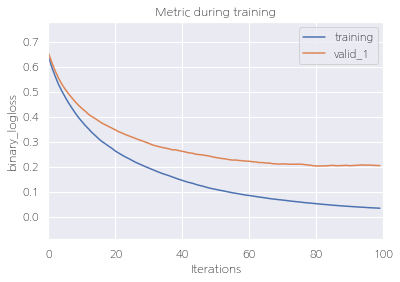

In [45]:
lgb.plot_metric(lgbm)

In [46]:
get_clf_eval(y_test, prediction)

오차행렬:
 [[134   5]
 [ 13 142]]

정확도: 0.9388
정밀도: 0.9660
재현율: 0.9161
F1: 0.9404
AUC: 0.9401


[Text(0.5, 1.0, '주가 상승하락 예측모델 특성 중요도'),
 Text(0.5, 0, '특성 중요도'),
 Text(0, 0.5, '특성')]

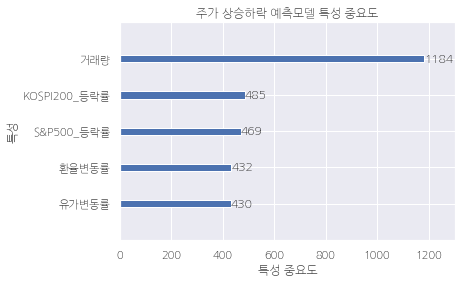

In [47]:
import seaborn as sns
plt.rcParams['font.family'] = 'NanumGothic'



ax = plot_importance(lgbm, importance_type='split')
ax.set(title=f'주가 상승하락 예측모델 특성 중요도',
    xlabel='특성 중요도',
    ylabel='특성')

### 자연어를 추가했더니 정확도가 떨어졌다 >> 중복일자 긍부정을 평균내서 다시 실행 해볼것.

## 해당 모델로 학습했을 경우 문제점 > 자연어 가중치 이외의 중복컬럼 학습효과로 인한 과적합

## 주가 상승 하락모델 (일자 중복 제거 및 긍부정 score 재산출)

In [48]:
df = pd.read_csv('redata.csv', encoding = 'utf-8')
data = df[['종목명','거래량','KOSPI200_등락률','환율변동률','유가변동률','S&P500_등락률','등락률','pred']]
data

,종목명,거래량,KOSPI200_등락률,환율변동률,유가변동률,S&P500_등락률,등락률,pred
0,SK이노베이션,217016,-1.16%,0.00%,-0.05%,0.29%,-2.33%,0.998798
1,현대차,556532,-1.16%,0.00%,-0.05%,0.29%,-2.07%,0.998799
2,LG 화학,165030,-1.16%,0.29%,3.12%,0.00%,-0.96%,0.998798
3,SK이노베이션,274987,-1.16%,0.29%,3.12%,0.84%,2.05%,0.998799
4,현대차,1145187,0.13%,0.29%,3.12%,0.84%,-1.69%,0.998799
...,...,...,...,...,...,...,...,...
524,삼성sdi,827634,0.35%,-0.32%,0.15%,0.87%,7.51%,0.998799
525,현대차,1488327,0.35%,-0.32%,0.15%,0.87%,0.53%,0.002367
526,SK이노베이션,976008,2.10%,-0.42%,0.58%,-0.22%,3.83%,0.998799
527,삼성sdi,503572,2.10%,-0.42%,0.58%,-0.22%,4.49%,0.500584


In [49]:
data = data.astype({'거래량': 'str'})
data['거래량'] = data['거래량'].str.replace('%', '')
data = data.astype({'거래량': 'float'})
data['거래량'] = data['거래량']

data = data.astype({'등락률': 'str'})
data['등락률'] = data['등락률'].str.replace('%', '')
data = data.astype({'등락률': 'float'})
data['등락률'] = data['등락률'] / 100

data = data.astype({'KOSPI200_등락률': 'str'})
data['KOSPI200_등락률'] = data['KOSPI200_등락률'].str.replace('%', '')
data = data.astype({'KOSPI200_등락률': 'float'})
data['KOSPI200_등락률'] = data['KOSPI200_등락률'] / 100

data = data.astype({'환율변동률': 'str'})
data['환율변동률'] = data['환율변동률'].str.replace('%', '')
data = data.astype({'환율변동률': 'float'})
data['환율변동률'] = data['환율변동률'] / 100

data = data.astype({'유가변동률': 'str'})
data['유가변동률'] = data['유가변동률'].str.replace('%', '')
data = data.astype({'유가변동률': 'float'})
data['유가변동률'] = data['유가변동률'] / 100

data = data.astype({'S&P500_등락률': 'str'})
data['S&P500_등락률'] = data['S&P500_등락률'].str.replace('%', '')
data = data.astype({'S&P500_등락률': 'float'})
data['S&P500_등락률'] = data['S&P500_등락률'] / 100


In [50]:
for x in range(len(data['등락률'])):
    if data['등락률'][x] > 0:
        data['등락률'][x] = 1
    else:
        data['등락률'][x] = 0
    
volume = []
for x in range(len(data['거래량'])):
    temp = (data['거래량'][x]-data['거래량'].min())/(data['거래량'].max()-data['거래량'].min())
    volume.append(temp)
    
    
for x in range(len(data['거래량'])):
    data['거래량'][x] = volume[x]


C:\Users\user\anaconda3\envs\atm\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\user\anaconda3\envs\atm\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\user\anaconda3\envs\atm\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

In [51]:
data

,종목명,거래량,KOSPI200_등락률,환율변동률,유가변동률,S&P500_등락률,등락률,pred
0,SK이노베이션,0.009961,-0.0116,0.0000,-0.0005,0.0029,0.0,0.998798
1,현대차,0.061206,-0.0116,0.0000,-0.0005,0.0029,0.0,0.998799
2,LG 화학,0.002114,-0.0116,0.0029,0.0312,0.0000,0.0,0.998798
3,SK이노베이션,0.018711,-0.0116,0.0029,0.0312,0.0084,1.0,0.998799
4,현대차,0.150054,0.0013,0.0029,0.0312,0.0084,0.0,0.998799
...,...,...,...,...,...,...,...,...
524,삼성sdi,0.102124,0.0035,-0.0032,0.0015,0.0087,1.0,0.998799
525,현대차,0.201846,0.0035,-0.0032,0.0015,0.0087,1.0,0.002367
526,SK이노베이션,0.124519,0.0210,-0.0042,0.0058,-0.0022,1.0,0.998799
527,삼성sdi,0.053212,0.0210,-0.0042,0.0058,-0.0022,1.0,0.500584


In [52]:
X_data = data[['거래량','KOSPI200_등락률','환율변동률','유가변동률','S&P500_등락률','pred']]
y_data = data[['등락률']]

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.20, random_state = 5)

In [54]:
lgbm = LGBMClassifier(random_state = 10, n_estimators=100)
model = lgbm.fit(X_train,y_train, verbose = True, eval_set = [(X_train, y_train), (X_test, y_test)], eval_metric = 'auc')
prediction = lgbm.predict(X_test)

[1]	training's auc: 0.852622	training's binary_logloss: 0.6528	valid_1's auc: 0.660688	valid_1's binary_logloss: 0.69275
[2]	training's auc: 0.852295	training's binary_logloss: 0.623359	valid_1's auc: 0.661775	valid_1's binary_logloss: 0.679738
[3]	training's auc: 0.853411	training's binary_logloss: 0.599157	valid_1's auc: 0.667391	valid_1's binary_logloss: 0.670492
[4]	training's auc: 0.87022	training's binary_logloss: 0.576865	valid_1's auc: 0.686957	valid_1's binary_logloss: 0.660696
[5]	training's auc: 0.876443	training's binary_logloss: 0.558063	valid_1's auc: 0.713043	valid_1's binary_logloss: 0.647993
[6]	training's auc: 0.88332	training's binary_logloss: 0.540521	valid_1's auc: 0.720652	valid_1's binary_logloss: 0.641577
[7]	training's auc: 0.89058	training's binary_logloss: 0.524092	valid_1's auc: 0.726268	valid_1's binary_logloss: 0.635179
[8]	training's auc: 0.897739	training's binary_logloss: 0.507786	valid_1's auc: 0.724275	valid_1's binary_logloss: 0.631924
[9]	training's

C:\Users\user\anaconda3\envs\atm\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [55]:
get_clf_eval(y_test, prediction)

오차행렬:
 [[42 18]
 [11 35]]

정확도: 0.7264
정밀도: 0.6604
재현율: 0.7609
F1: 0.7071
AUC: 0.7304


C:\Users\user\anaconda3\envs\atm\lib\site-packages\lightgbm\plotting.py:328: UserWarning: More than one metric available, picking one to plot.
  _log_warning("More than one metric available, picking one to plot.")


<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

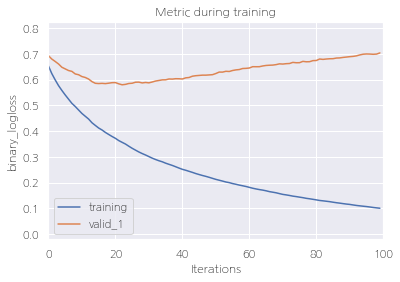

In [56]:
lgb.plot_metric(model)

[Text(0.5, 1.0, '주가 상승하락 예측모델 특성 중요도'),
 Text(0.5, 0, '특성 중요도'),
 Text(0, 0.5, '특성')]

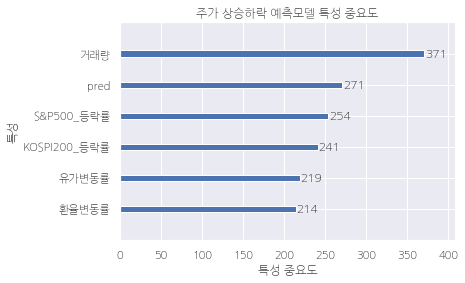

In [57]:
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams.update({'font.size':12})


ax = plot_importance(lgbm, importance_type='split')
ax.set(title=f'주가 상승하락 예측모델 특성 중요도',
    xlabel='특성 중요도',
    ylabel='특성')

## 중복일자 제거 후 상승 하락 모델 (자연어 x)

In [58]:
data = df[['종목명','거래량','KOSPI200_등락률','환율변동률','유가변동률','S&P500_등락률','등락률']]
data

,종목명,거래량,KOSPI200_등락률,환율변동률,유가변동률,S&P500_등락률,등락률
0,SK이노베이션,217016,-1.16%,0.00%,-0.05%,0.29%,-2.33%
1,현대차,556532,-1.16%,0.00%,-0.05%,0.29%,-2.07%
2,LG 화학,165030,-1.16%,0.29%,3.12%,0.00%,-0.96%
3,SK이노베이션,274987,-1.16%,0.29%,3.12%,0.84%,2.05%
4,현대차,1145187,0.13%,0.29%,3.12%,0.84%,-1.69%
...,...,...,...,...,...,...,...
524,삼성sdi,827634,0.35%,-0.32%,0.15%,0.87%,7.51%
525,현대차,1488327,0.35%,-0.32%,0.15%,0.87%,0.53%
526,SK이노베이션,976008,2.10%,-0.42%,0.58%,-0.22%,3.83%
527,삼성sdi,503572,2.10%,-0.42%,0.58%,-0.22%,4.49%


In [59]:
data = data.astype({'거래량': 'str'})
data['거래량'] = data['거래량'].str.replace('%', '')
data = data.astype({'거래량': 'float'})
data['거래량'] = data['거래량']

data = data.astype({'등락률': 'str'})
data['등락률'] = data['등락률'].str.replace('%', '')
data = data.astype({'등락률': 'float'})
data['등락률'] = data['등락률'] / 100

data = data.astype({'KOSPI200_등락률': 'str'})
data['KOSPI200_등락률'] = data['KOSPI200_등락률'].str.replace('%', '')
data = data.astype({'KOSPI200_등락률': 'float'})
data['KOSPI200_등락률'] = data['KOSPI200_등락률'] / 100

data = data.astype({'환율변동률': 'str'})
data['환율변동률'] = data['환율변동률'].str.replace('%', '')
data = data.astype({'환율변동률': 'float'})
data['환율변동률'] = data['환율변동률'] / 100

data = data.astype({'유가변동률': 'str'})
data['유가변동률'] = data['유가변동률'].str.replace('%', '')
data = data.astype({'유가변동률': 'float'})
data['유가변동률'] = data['유가변동률'] / 100

data = data.astype({'S&P500_등락률': 'str'})
data['S&P500_등락률'] = data['S&P500_등락률'].str.replace('%', '')
data = data.astype({'S&P500_등락률': 'float'})
data['S&P500_등락률'] = data['S&P500_등락률'] / 100


In [60]:
for x in range(len(data['등락률'])):
    if data['등락률'][x] > 0:
        data['등락률'][x] = 1
    else:
        data['등락률'][x] = 0
    
volume = []
for x in range(len(data['거래량'])):
    temp = (data['거래량'][x]-data['거래량'].min())/(data['거래량'].max()-data['거래량'].min())
    volume.append(temp)
    
    
for x in range(len(data['거래량'])):
    data['거래량'][x] = volume[x]


C:\Users\user\anaconda3\envs\atm\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\user\anaconda3\envs\atm\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\user\anaconda3\envs\atm\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

In [61]:
X_data = data[['거래량','KOSPI200_등락률','환율변동률','유가변동률','S&P500_등락률']]
y_data = data[['등락률']]

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.20, random_state = 5)

In [63]:
lgbm = LGBMClassifier(random_state = 10)
model = lgbm.fit(X_train,y_train, verbose = True, eval_set = [(X_train, y_train), (X_test, y_test)], eval_metric = 'loss')
prediction = lgbm.predict(X_test)

[1]	training's binary_logloss: 0.65227	valid_1's binary_logloss: 0.691579
[2]	training's binary_logloss: 0.622743	valid_1's binary_logloss: 0.678565
[3]	training's binary_logloss: 0.597551	valid_1's binary_logloss: 0.666949
[4]	training's binary_logloss: 0.576253	valid_1's binary_logloss: 0.659271
[5]	training's binary_logloss: 0.557455	valid_1's binary_logloss: 0.652134
[6]	training's binary_logloss: 0.54205	valid_1's binary_logloss: 0.644131
[7]	training's binary_logloss: 0.527006	valid_1's binary_logloss: 0.642958
[8]	training's binary_logloss: 0.511575	valid_1's binary_logloss: 0.635581
[9]	training's binary_logloss: 0.498324	valid_1's binary_logloss: 0.627804
[10]	training's binary_logloss: 0.48673	valid_1's binary_logloss: 0.619668
[11]	training's binary_logloss: 0.474334	valid_1's binary_logloss: 0.615872
[12]	training's binary_logloss: 0.463714	valid_1's binary_logloss: 0.611985
[13]	training's binary_logloss: 0.453331	valid_1's binary_logloss: 0.607721
[14]	training's binary_l

C:\Users\user\anaconda3\envs\atm\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

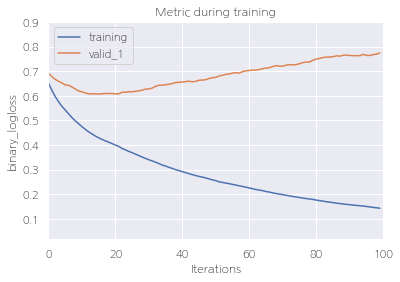

In [64]:
lgb.plot_metric(model)

In [65]:
get_clf_eval(y_test, prediction)

오차행렬:
 [[36 24]
 [11 35]]

정확도: 0.6698
정밀도: 0.5932
재현율: 0.7609
F1: 0.6667
AUC: 0.6804


[Text(0.5, 1.0, '주가 상승하락 예측모델 특성 중요도'),
 Text(0.5, 0, '특성 중요도'),
 Text(0, 0.5, '특성')]

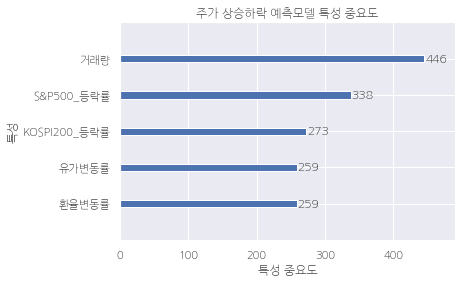

In [66]:
import seaborn as sns
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams.update({'font.size':12})


ax = plot_importance(lgbm, importance_type='split')
ax.set(title=f'주가 상승하락 예측모델 특성 중요도',
    xlabel='특성 중요도',
    ylabel='특성')

# 등락률 예측 모델 (자연어 x)

In [67]:
df = pd.read_csv("redata.csv")
data = df.loc[:,['종목명','등락률', '거래량','KOSPI200_등락률','환율변동률','유가변동률','S&P500_등락률']]

data.head()

,종목명,등락률,거래량,KOSPI200_등락률,환율변동률,유가변동률,S&P500_등락률
0,SK이노베이션,-2.33%,217016,-1.16%,0.00%,-0.05%,0.29%
1,현대차,-2.07%,556532,-1.16%,0.00%,-0.05%,0.29%
2,LG 화학,-0.96%,165030,-1.16%,0.29%,3.12%,0.00%
3,SK이노베이션,2.05%,274987,-1.16%,0.29%,3.12%,0.84%
4,현대차,-1.69%,1145187,0.13%,0.29%,3.12%,0.84%


In [68]:
data = data.astype({'거래량': 'str'})
data['거래량'] = data['거래량'].str.replace('%', '')
data = data.astype({'거래량': 'float'})
data['거래량'] = data['거래량']

data = data.astype({'등락률': 'str'})
data['등락률'] = data['등락률'].str.replace('%', '')
data = data.astype({'등락률': 'float'})
data['등락률'] = data['등락률'] / 100

data = data.astype({'KOSPI200_등락률': 'str'})
data['KOSPI200_등락률'] = data['KOSPI200_등락률'].str.replace('%', '')
data = data.astype({'KOSPI200_등락률': 'float'})
data['KOSPI200_등락률'] = data['KOSPI200_등락률'] / 100

data = data.astype({'환율변동률': 'str'})
data['환율변동률'] = data['환율변동률'].str.replace('%', '')
data = data.astype({'환율변동률': 'float'})
data['환율변동률'] = data['환율변동률'] / 100

data = data.astype({'유가변동률': 'str'})
data['유가변동률'] = data['유가변동률'].str.replace('%', '')
data = data.astype({'유가변동률': 'float'})
data['유가변동률'] = data['유가변동률'] / 100

data = data.astype({'S&P500_등락률': 'str'})
data['S&P500_등락률'] = data['S&P500_등락률'].str.replace('%', '')
data = data.astype({'S&P500_등락률': 'float'})
data['S&P500_등락률'] = data['S&P500_등락률'] / 100


In [69]:
uprate = []
for x in range(len(data['등락률'])):
    temp = (data['등락률'][x]+0.3)/0.6
    uprate.append(temp)
    
for x in range(len(data['등락률'])):
    data['등락률'][x] = uprate[x]
    
    
volume = []
for x in range(len(data['거래량'])):
    temp = (data['거래량'][x]-data['거래량'].min())/(data['거래량'].max()-data['거래량'].min())
    volume.append(temp)
    
    
for x in range(len(data['거래량'])):
    data['거래량'][x] = volume[x]


C:\Users\user\anaconda3\envs\atm\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\user\anaconda3\envs\atm\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [70]:
data

,종목명,등락률,거래량,KOSPI200_등락률,환율변동률,유가변동률,S&P500_등락률
0,SK이노베이션,0.461167,0.009961,-0.0116,0.0000,-0.0005,0.0029
1,현대차,0.465500,0.061206,-0.0116,0.0000,-0.0005,0.0029
2,LG 화학,0.484000,0.002114,-0.0116,0.0029,0.0312,0.0000
3,SK이노베이션,0.534167,0.018711,-0.0116,0.0029,0.0312,0.0084
4,현대차,0.471833,0.150054,0.0013,0.0029,0.0312,0.0084
...,...,...,...,...,...,...,...
524,삼성sdi,0.625167,0.102124,0.0035,-0.0032,0.0015,0.0087
525,현대차,0.508833,0.201846,0.0035,-0.0032,0.0015,0.0087
526,SK이노베이션,0.563833,0.124519,0.0210,-0.0042,0.0058,-0.0022
527,삼성sdi,0.574833,0.053212,0.0210,-0.0042,0.0058,-0.0022


In [71]:
X_data = data[['거래량','KOSPI200_등락률','환율변동률','유가변동률','S&P500_등락률']]
y_data = data[['등락률']]

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.20, random_state = 6)

In [73]:
model = LGBMRegressor(num_leaves=31, max_depth= 10, subsample= 0.4, colsample_bytree= 1, learning_rate=0.1, n_estimators=70)
model.fit(X_train, y_train, verbose = True, eval_set = [(X_train, y_train), (X_test, y_test)], eval_metric = 'loss')
y_predict = model.predict(X_test)

[1]	training's l2: 0.00308013	valid_1's l2: 0.00239898
[2]	training's l2: 0.0028178	valid_1's l2: 0.00223134
[3]	training's l2: 0.00260871	valid_1's l2: 0.00210824
[4]	training's l2: 0.00242733	valid_1's l2: 0.00198782
[5]	training's l2: 0.00228004	valid_1's l2: 0.00188307
[6]	training's l2: 0.0021527	valid_1's l2: 0.00181807
[7]	training's l2: 0.00204686	valid_1's l2: 0.00173277
[8]	training's l2: 0.00195782	valid_1's l2: 0.00168339
[9]	training's l2: 0.00188064	valid_1's l2: 0.00162874
[10]	training's l2: 0.00181473	valid_1's l2: 0.00160923
[11]	training's l2: 0.00176213	valid_1's l2: 0.00157871
[12]	training's l2: 0.00169846	valid_1's l2: 0.00153382
[13]	training's l2: 0.00164661	valid_1's l2: 0.0015292
[14]	training's l2: 0.00160863	valid_1's l2: 0.00151984
[15]	training's l2: 0.00156761	valid_1's l2: 0.00150587
[16]	training's l2: 0.00153393	valid_1's l2: 0.00148581
[17]	training's l2: 0.00150123	valid_1's l2: 0.00150025
[18]	training's l2: 0.00146451	valid_1's l2: 0.00147864
[19]

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='l2'>

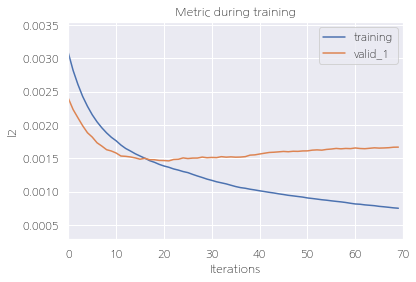

In [74]:
lgb.plot_metric(model)

In [75]:
X_test.shape

(106, 5)

In [76]:
y_test = np.array(y_test)

In [77]:
mean_absolute_error(y_test, y_predict)

0.032396887020750206

C:\Users\user\anaconda3\envs\atm\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\user\anaconda3\envs\atm\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


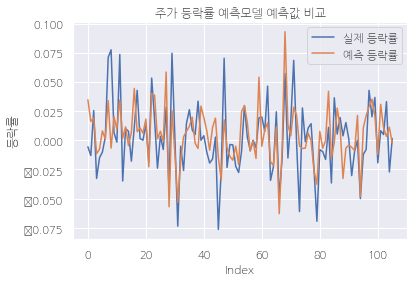

In [78]:
plt.figure()
plt.plot(y_test*0.6-0.3, label = '실제 등락률')
plt.plot(y_predict*0.6-0.3, label = '예측 등락률')
plt.title('주가 등락률 예측모델 예측값 비교')
plt.xlabel('Index')
plt.ylabel('등락률')
plt.legend()
plt.show()

[Text(0.5, 1.0, '주가 등락률 예측모델 특성 중요도'),
 Text(0.5, 0, '특성 중요도'),
 Text(0, 0.5, '특성')]

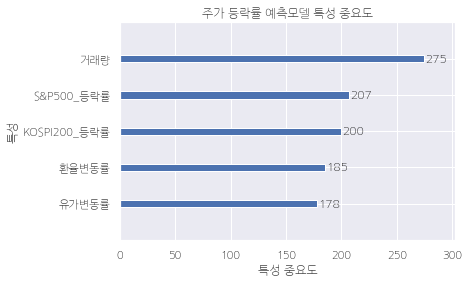

In [79]:
import seaborn as sns
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams.update({'font.size':12})


ax = plot_importance(model, importance_type='split')
ax.set(title=f'주가 등락률 예측모델 특성 중요도',
    xlabel='특성 중요도',
    ylabel='특성')

# 등락률 예측 (자연어 추가)

In [80]:
df = pd.read_csv("redata.csv")
data = df.loc[:,['종목명','pred','등락률', '거래량','KOSPI200_등락률','환율변동률','유가변동률','S&P500_등락률']]

data.head()

,종목명,pred,등락률,거래량,KOSPI200_등락률,환율변동률,유가변동률,S&P500_등락률
0,SK이노베이션,0.998798,-2.33%,217016,-1.16%,0.00%,-0.05%,0.29%
1,현대차,0.998799,-2.07%,556532,-1.16%,0.00%,-0.05%,0.29%
2,LG 화학,0.998798,-0.96%,165030,-1.16%,0.29%,3.12%,0.00%
3,SK이노베이션,0.998799,2.05%,274987,-1.16%,0.29%,3.12%,0.84%
4,현대차,0.998799,-1.69%,1145187,0.13%,0.29%,3.12%,0.84%


In [81]:
data = data.astype({'거래량': 'str'})
data['거래량'] = data['거래량'].str.replace('%', '')
data = data.astype({'거래량': 'float'})
data['거래량'] = data['거래량']

data = data.astype({'등락률': 'str'})
data['등락률'] = data['등락률'].str.replace('%', '')
data = data.astype({'등락률': 'float'})
data['등락률'] = data['등락률'] / 100

data = data.astype({'KOSPI200_등락률': 'str'})
data['KOSPI200_등락률'] = data['KOSPI200_등락률'].str.replace('%', '')
data = data.astype({'KOSPI200_등락률': 'float'})
data['KOSPI200_등락률'] = data['KOSPI200_등락률'] / 100

data = data.astype({'환율변동률': 'str'})
data['환율변동률'] = data['환율변동률'].str.replace('%', '')
data = data.astype({'환율변동률': 'float'})
data['환율변동률'] = data['환율변동률'] / 100

data = data.astype({'유가변동률': 'str'})
data['유가변동률'] = data['유가변동률'].str.replace('%', '')
data = data.astype({'유가변동률': 'float'})
data['유가변동률'] = data['유가변동률'] / 100

data = data.astype({'S&P500_등락률': 'str'})
data['S&P500_등락률'] = data['S&P500_등락률'].str.replace('%', '')
data = data.astype({'S&P500_등락률': 'float'})
data['S&P500_등락률'] = data['S&P500_등락률'] / 100

uprate = []
for x in range(len(data['등락률'])):
    temp = (data['등락률'][x]+0.3)/0.6
    uprate.append(temp)
    
for x in range(len(data['등락률'])):
    data['등락률'][x] = uprate[x]
    
    
volume = []
for x in range(len(data['거래량'])):
    temp = (data['거래량'][x]-data['거래량'].min())/(data['거래량'].max()-data['거래량'].min())
    volume.append(temp)
    
    
for x in range(len(data['거래량'])):
    data['거래량'][x] = volume[x]


C:\Users\user\anaconda3\envs\atm\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user\anaconda3\envs\atm\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [82]:
X_data = data[['거래량','KOSPI200_등락률','환율변동률','유가변동률','S&P500_등락률', 'pred']]
y_data = data[['등락률']]

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.20, random_state = 6)

model = LGBMRegressor(num_leaves=31, max_depth= 10, subsample= 0.4, colsample_bytree= 1, learning_rate=0.1, n_estimators=70)
model.fit(X_train, y_train, verbose = True, eval_set = [(X_train, y_train), (X_test, y_test)], eval_metric = 'loss')
y_predict = model.predict(X_test)

[1]	training's l2: 0.00307828	valid_1's l2: 0.00240171
[2]	training's l2: 0.00282714	valid_1's l2: 0.0022308
[3]	training's l2: 0.00260032	valid_1's l2: 0.00210551
[4]	training's l2: 0.00241354	valid_1's l2: 0.00199091
[5]	training's l2: 0.00226655	valid_1's l2: 0.00189954
[6]	training's l2: 0.00213473	valid_1's l2: 0.00182803
[7]	training's l2: 0.00202275	valid_1's l2: 0.00176487
[8]	training's l2: 0.00192672	valid_1's l2: 0.00168965
[9]	training's l2: 0.00183379	valid_1's l2: 0.00165447
[10]	training's l2: 0.00175987	valid_1's l2: 0.00162599
[11]	training's l2: 0.00168165	valid_1's l2: 0.00158678
[12]	training's l2: 0.00162006	valid_1's l2: 0.00156554
[13]	training's l2: 0.00156813	valid_1's l2: 0.00154926
[14]	training's l2: 0.00151946	valid_1's l2: 0.00152874
[15]	training's l2: 0.00147833	valid_1's l2: 0.00150246
[16]	training's l2: 0.00144478	valid_1's l2: 0.00149275
[17]	training's l2: 0.00141326	valid_1's l2: 0.00148904
[18]	training's l2: 0.0013727	valid_1's l2: 0.00147914
[19

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='l2'>

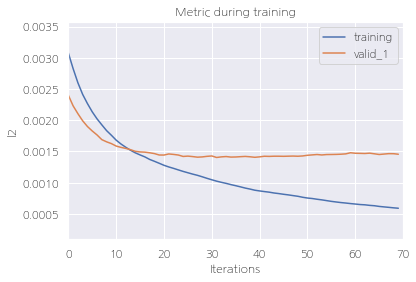

In [84]:
lgb.plot_metric(model)

In [85]:
y_test = np.array(y_test)

In [86]:
mean_absolute_error(y_test, y_predict)

0.030472852705220845

C:\Users\user\anaconda3\envs\atm\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\user\anaconda3\envs\atm\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


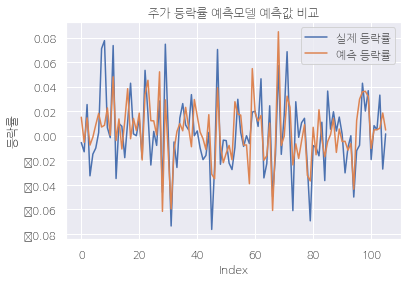

In [87]:
plt.figure()
plt.plot(y_test*0.6-0.3, label = '실제 등락률')
plt.plot(y_predict*0.6-0.3, label = '예측 등락률')
plt.title('주가 등락률 예측모델 예측값 비교')
plt.xlabel('Index')
plt.ylabel('등락률')
plt.legend()
plt.show()

[Text(0.5, 1.0, '주가 등락률 예측모델 특성 중요도'),
 Text(0.5, 0, '특성 중요도'),
 Text(0, 0.5, '특성')]

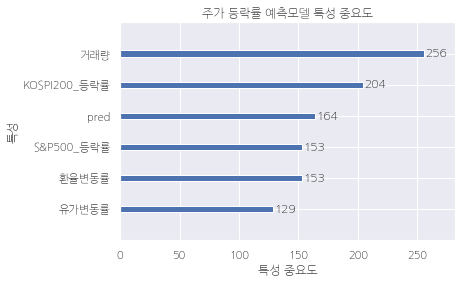

In [88]:
import seaborn as sns
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams.update({'font.size':12})


ax = plot_importance(model, importance_type='split')
ax.set(title=f'주가 등락률 예측모델 특성 중요도',
    xlabel='특성 중요도',
    ylabel='특성')